<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/Jhee/RF%26LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreProcessing

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile


In [81]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 634, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 634 (delta 75), reused 25 (delta 25), pack-reused 517 (from 3)
Receiving objects: 100% (634/634), 67.16 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (328/328), done.
/content/DATCapstone/data/DATCapstone/data/DATCapstone/data/DATCapstone/data


In [82]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [83]:


df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
149,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,NaN,NaN,NaN,NaN,NaN,1.128571,1.756653,10.863785,9.008606,AAPL
152,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,-3.444626,0.245331,7.016815,0.616699,AAPL
155,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.933334,3.601639,9.637100,-0.162491,AAPL
158,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,0.873398,0.392532,8.744034,2.098389,AAPL
161,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,NaN,NaN,NaN,NaN,NaN,1.265976,-1.069687,9.313263,4.827057,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8062,2025-01-27,394.799988,406.690002,389.000000,397.149994,58125500,0.0,0.0,29723.864,4.0,...,1.174326,-0.262426,0.298183,0.182200,0.388200,0.940002,NaN,NaN,NaN,TSLA
8072,2025-01-28,396.910004,400.589996,386.500000,398.089996,48910700,0.0,0.0,29723.864,4.0,...,0.084330,-0.354550,-0.611864,-0.449780,0.584349,-8.989990,NaN,NaN,NaN,TSLA
8082,2025-01-29,395.209991,398.589996,384.480011,389.100006,68033600,0.0,0.0,29723.864,4.0,...,0.827862,-0.620100,-0.024186,-0.439615,0.781107,11.179993,NaN,NaN,NaN,TSLA
8092,2025-01-30,410.779999,412.500000,384.410004,400.279999,98092900,0.0,0.0,29723.864,4.0,...,1.383147,-0.616897,-0.145329,-0.418483,0.636253,4.320007,NaN,NaN,NaN,TSLA


In [84]:
#Read Data
# df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
# Correct path for ZIP file
zip_path = '/content/DATCapstone/data/_data.csv.zip'

# Extract specific file from ZIP
with ZipFile(zip_path, 'r') as z:
    with z.open('data.csv') as f:  # Explicitly specify the file to extract
        df = pd.read_csv(f, index_col=0)


df['Date'] = pd.to_datetime(df['Date'])

#Forward fill -> micro, macro, stock / fill na -> sentiment
df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

# Sorting
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# Lag feature (Exclude embedding columns)
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]
lag_features = []

for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

lag_df = pd.concat(lag_features, axis=1)

df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

In [85]:
import glob
import os

# Read articles df
csv_files = glob.glob(os.path.join(os.getcwd(), "*articles*.csv"))

df_articles_list = []

for file in csv_files:
    # get ticker from filename
    ticker = os.path.basename(file).split('_')[0]
    df_articles = pd.read_csv(file)
    df_articles['Ticker'] = ticker
    df_articles_list.append(df_articles)

# concat articles dataframe
df_articles = pd.concat(df_articles_list, ignore_index=True)

# Articles dataframe preprocessing
df_articles["Date"] = pd.to_datetime(df_articles["time"], errors='coerce', utc=True).dt.tz_convert(None).dt.date
df_articles = df_articles[['Date', 'Ticker', 'sentiment']]
sentiment_dummies = pd.get_dummies(df_articles['sentiment'])
df_encoded = pd.concat([df_articles[['Date', 'Ticker']], sentiment_dummies], axis=1)
df_articles = df_encoded.groupby(['Date', 'Ticker']).sum().reset_index()
df_articles['Date'] = pd.to_datetime(df_articles['Date'])

df_articles['articles_avg_sentiment'] = (df_articles['Negative'] * -1 + df_articles['Neutral'] * 0 + df_articles['Positive']) / (df_articles['Negative'] + df_articles['Neutral'] + df_articles['Positive'])
df_articles.columns = ['Date', 'Ticker', 'Articles_Negative', 'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment']
df_articles

df = pd.merge(df, df_articles, on=['Date', 'Ticker'], how = 'left')

# Fill 0 except the target columns
df[[col for col in df.columns if 'Target' not in col]] = df[[col for col in df.columns if 'Target' not in col]].fillna(0)

In [86]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# PCA columns
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)
df_non_pca = df.drop(columns=emb_cols)

df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_74,emb_pca_75,emb_pca_76,emb_pca_77,emb_pca_78,emb_pca_79,emb_pca_80,emb_pca_81,emb_pca_82,emb_pca_83
0,2021-09-30,140.983670,141.690258,138.648004,138.863907,89056700,0.0,0.0,23921.991,4.7,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
1,2021-10-01,139.256450,140.257452,136.518433,139.992477,94639600,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
2,2021-10-04,139.119037,139.560665,135.694064,136.547852,98322000,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
3,2021-10-05,136.891371,139.590139,136.763788,138.481186,80861100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022
4,2021-10-06,136.871718,139.501783,135.792205,139.354584,83221100,0.0,0.0,24777.038,4.5,...,-0.000573,-0.000315,-0.000716,-0.000052,0.000158,0.000176,0.000412,-0.000354,-0.000744,0.000022


In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
random_forest(df, 'Target_1day')
random_forest(df, 'Target_1week')
random_forest(df, 'Target_1month')
random_forest(df, 'Target_1year')

Fitting 3 folds for each of 6 candidates, totalling 18 fits


KeyboardInterrupt: 

In [ ]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [88]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()

    # Target setting
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    df['Date'] = pd.to_datetime(df['Date'])

    # Ticker encoding
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y
    y = df[target]
    X = df.drop(columns=['Date', target])

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # Hyperparameter
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbosity=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # Prediction
    y_pred = best_model.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Visualization
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
lightgbm_model(df, 'Target_1day')
lightgbm_model(df, 'Target_1week')
lightgbm_model(df, 'Target_1month')
lightgbm_model(df, 'Target_1year')

In [ ]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')

In [89]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'GDP (Billions USD)', 'Unemployment Rate (%)',
       ...
       'positive_lag1', 'positive_lag3', 'positive_lag5', 'positive_lag7',
       'positive_lag14', 'positive_lag30', 'Articles_Negative',
       'Articles_Neutral', 'Articles_positive', 'Articles_avg_sentiment'],
      dtype='object', length=1079)


LSTM

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Filter to only one company, like AAPL
# selected_ticker = "AAPL"
# df_single = df[df['Ticker'] == selected_ticker].copy()
# df_single = df_single.sort_values(by="Date").reset_index(drop=True)


In [105]:
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)
df["time_idx"] = df.groupby("Ticker").cumcount()

# feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP (Billions USD)', 'Unemployment Rate (%)',
#                 'positive', 'neutral', 'negative']

feature_cols = [col for col in df.columns if 'Target' not in col and col not in ['Date', 'Ticker', 'time_idx']]

target_col = "Target_1day"

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [107]:
def create_sequences(X, y, look_back=30):
    Xs, ys = [], []
    for i in range(look_back, len(X)):
        Xs.append(X[i-look_back:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test)


In [108]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [109]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)


Epoch 1/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 277.9181 - val_loss: 603.9171
Epoch 2/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - loss: 32280.1582 - val_loss: 520.7653
Epoch 3/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 285.5779 - val_loss: 534.4707
Epoch 4/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - loss: 547.9110 - val_loss: 1867.4619
Epoch 5/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 844.2625 - val_loss: 3253.2285
Epoch 6/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 51360.0117 - val_loss: 3114.8176
Epoch 7/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 1460.2808 - val_loss: 628.6103
Epoch 8/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 871.6159 - val_loss: 645.8596
Epoch 9/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 873.3066 - val_loss: 593.0860
Epoch 10/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 895.1097 - val_loss: 512.0760
Epoch 11/20
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 941.7191

In [110]:
y_pred = model.predict(X_test_seq).flatten()

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [111]:
y_pred = model.predict(X_test_seq).flatten()

mae = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
r2 = r2_score(y_test_seq, y_pred)

print(f"LSTM Results for {selected_ticker} - Target_1day")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
LSTM Results for AAPL - Target_1day
MAE: 11.19
RMSE: 14.01
R²  : -13.9133


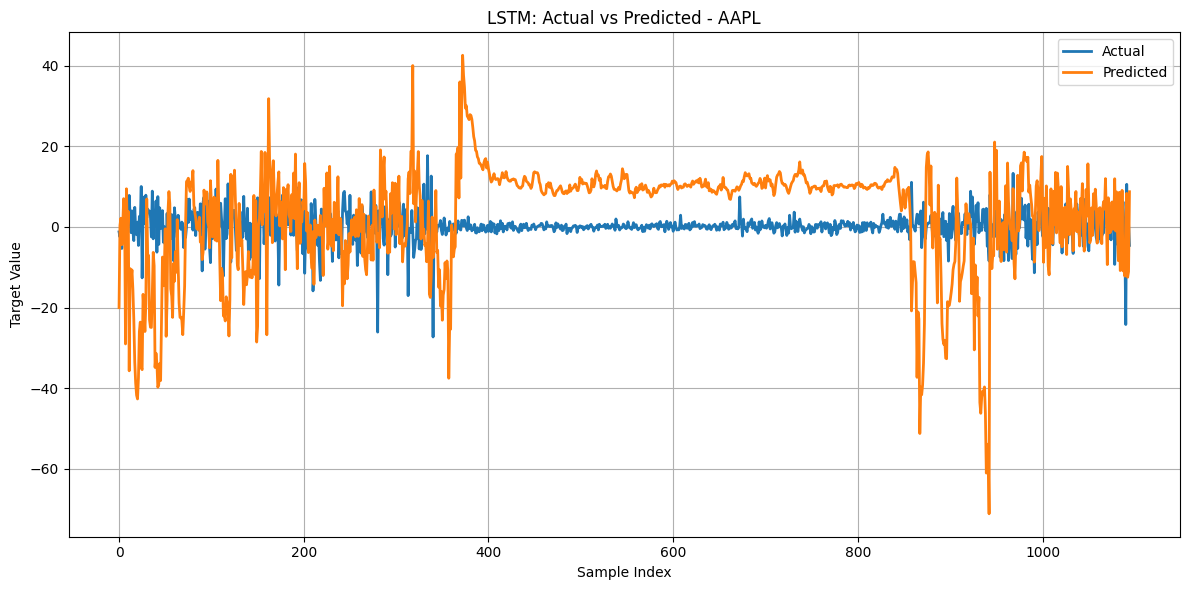

In [112]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linewidth=2)
plt.title(f'LSTM: Actual vs Predicted - {selected_ticker}')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


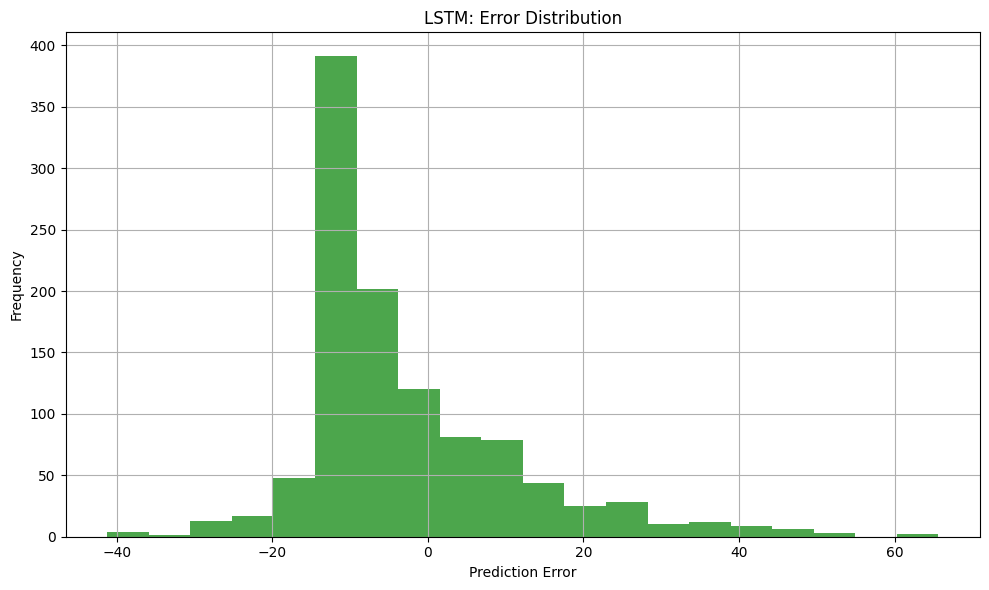

In [113]:
errors = y_test_seq - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, color='green', alpha=0.7)
plt.title("LSTM: Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


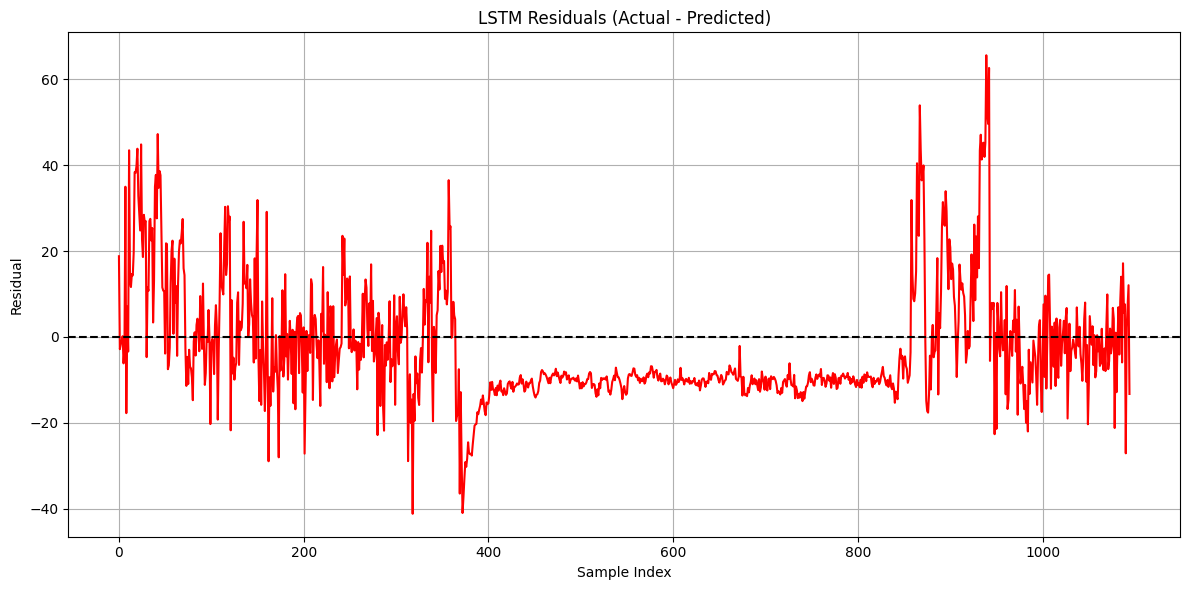

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(errors, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('LSTM Residuals (Actual - Predicted)')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()



Training LSTM for Target_1day...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


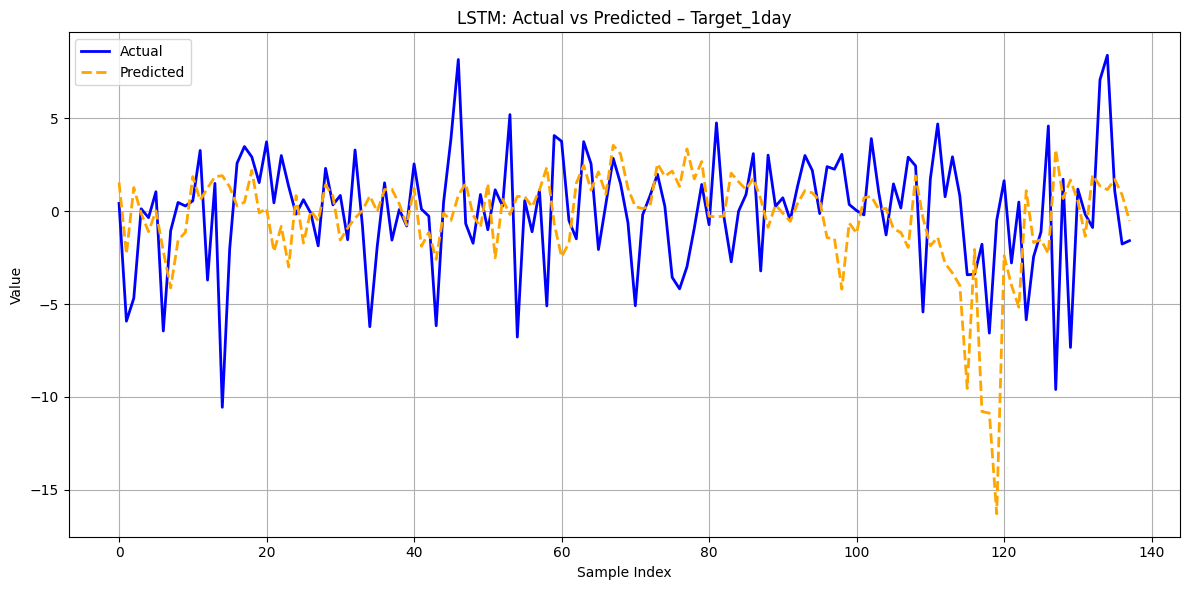

Target_1day – MAE: 2.92, RMSE: 4.00

Training LSTM for Target_1week...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


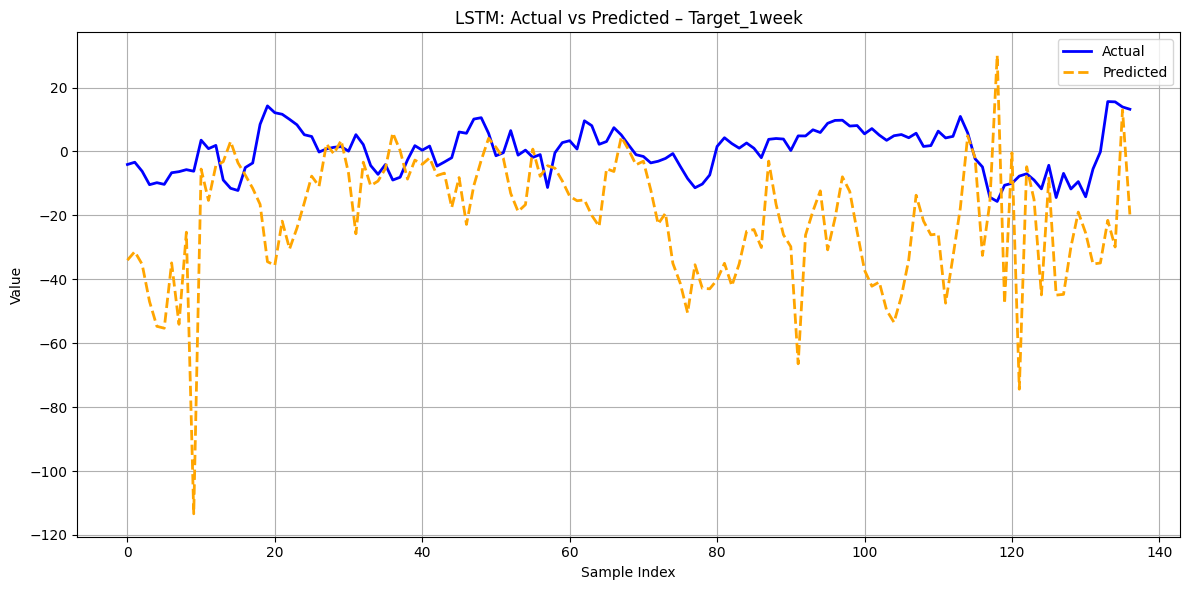

Target_1week – MAE: 22.95, RMSE: 28.98

Training LSTM for Target_1month...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


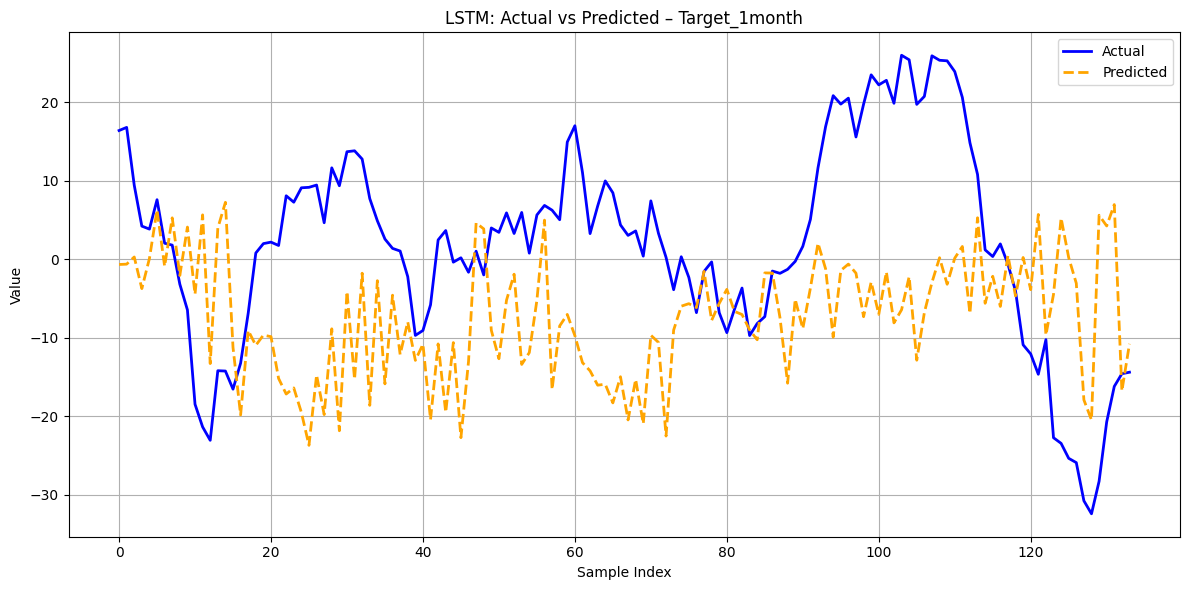

Target_1month – MAE: 14.94, RMSE: 17.77

Training LSTM for Target_1year...



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


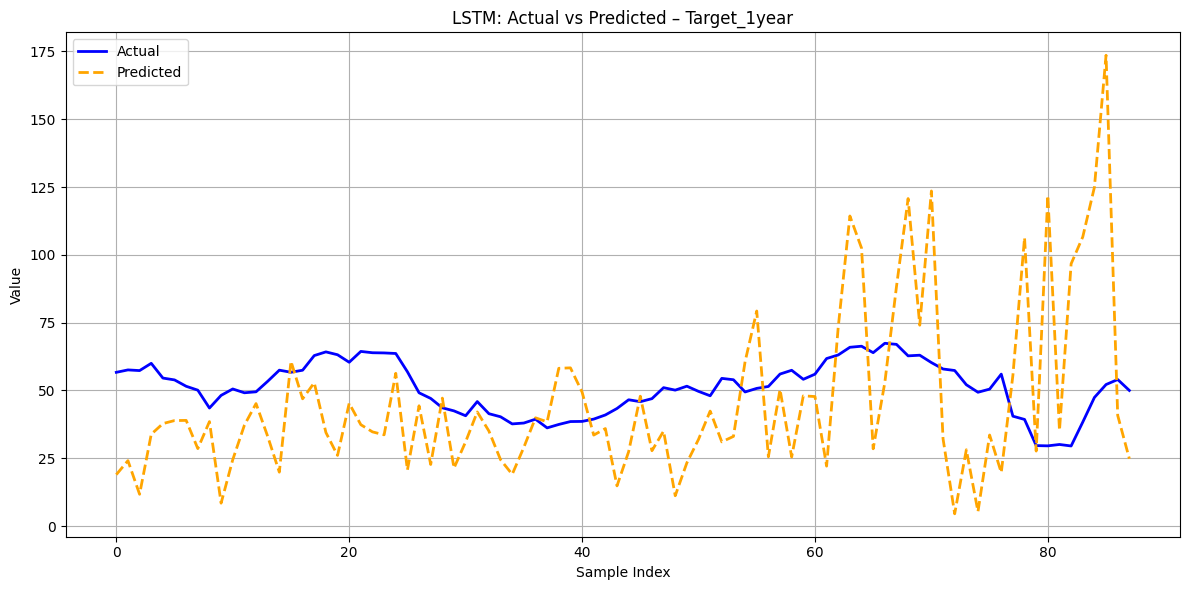

Target_1year – MAE: 25.03, RMSE: 32.81


In [118]:
look_back = 30
selected_ticker = "AAPL"  # Replace with your chosen company

for target_col in ['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']:
    print(f"\nTraining LSTM for {target_col}...\n")

    df_single = df[df['Ticker'] == selected_ticker].copy()
    df_single = df_single.dropna(subset=[target_col])

    # Feature scaling
    X = df_single[feature_cols].values
    y = df_single[target_col].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train, look_back)
    X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test, look_back)

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    history = model.fit(
        X_seq_train, y_seq_train,
        epochs=20,
        batch_size=16,
        validation_data=(X_seq_test, y_seq_test),
        verbose=0
    )

    y_pred = model.predict(X_seq_test).flatten()

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_seq_test, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"LSTM: Actual vs Predicted – {target_col}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    mae = mean_absolute_error(y_seq_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_seq_test, y_pred))

    print(f"{target_col} – MAE: {mae:.2f}, RMSE: {rmse:.2f}")


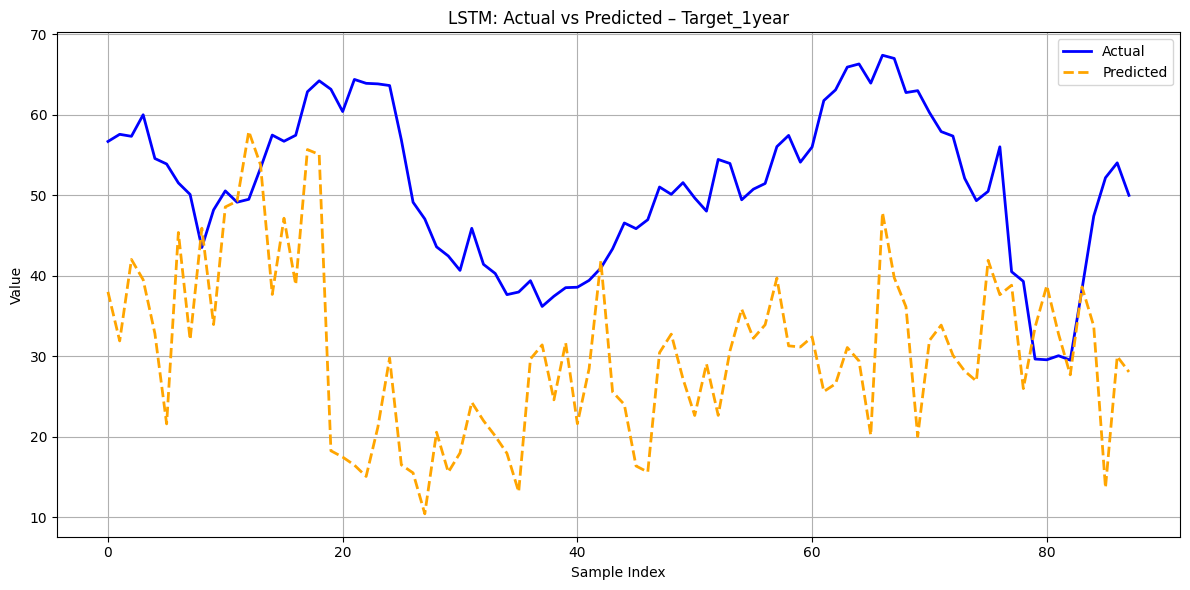

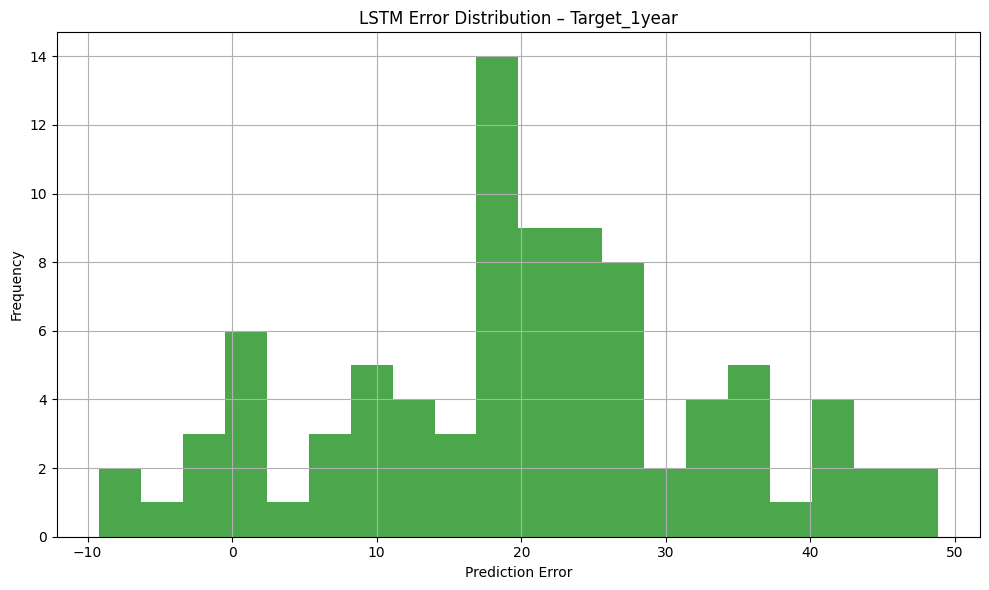

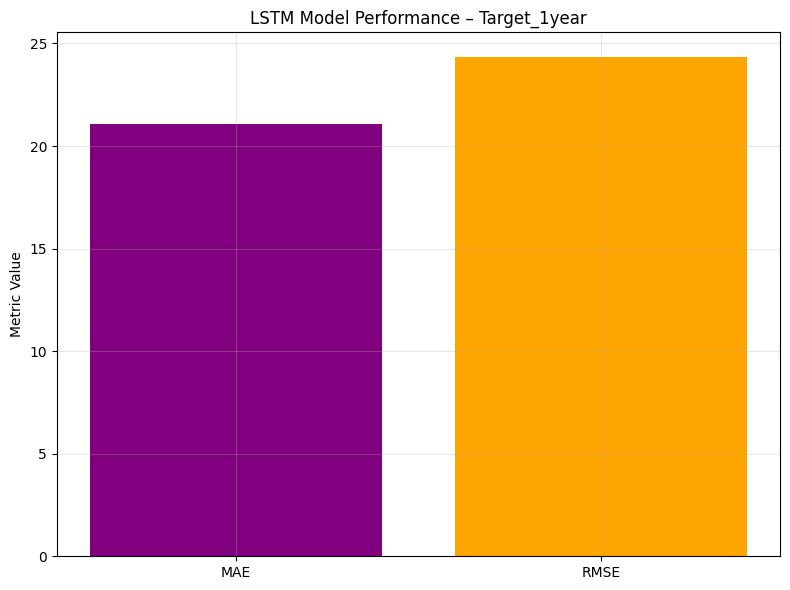

In [116]:
    # 📊 Visualization: Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(y_seq_test, label='Actual', color='blue', linewidth=2)
    plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
    plt.title(f"LSTM: Actual vs Predicted – {target_col}")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📉 Error Distribution
    errors = y_seq_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, color="green", alpha=0.7)
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title(f"LSTM Error Distribution – {target_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📋 Metrics Bar Chart
    metrics = {"MAE": mae, "RMSE": rmse}
    plt.figure(figsize=(8, 6))
    plt.bar(metrics.keys(), metrics.values(), color=["purple", "orange"])
    plt.ylabel("Metric Value")
    plt.title(f"LSTM Model Performance – {target_col}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
